Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
from glob import glob

In [6]:
!pip install Augmentor

In [7]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("../input/melanoma-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('../input/melanoma-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    #**kwargs
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-11-14 18:04:36.406385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 18:04:36.510036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 18:04:36.511008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 18:04:36.514494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    #**kwargs
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
from glob import glob

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2022-11-14 18:04:39.542914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


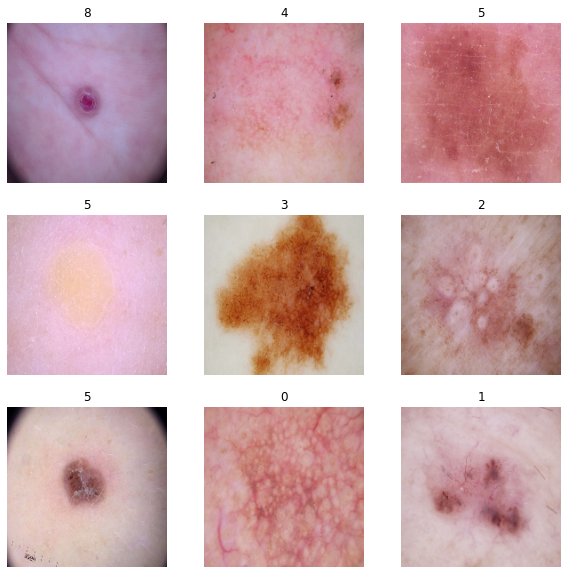

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# plotting some random 10 images

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
num_classes = 9
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model M1

In [17]:
num_class = 9
model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_class,activation='softmax')
    #layers.Dense(num_class)
])

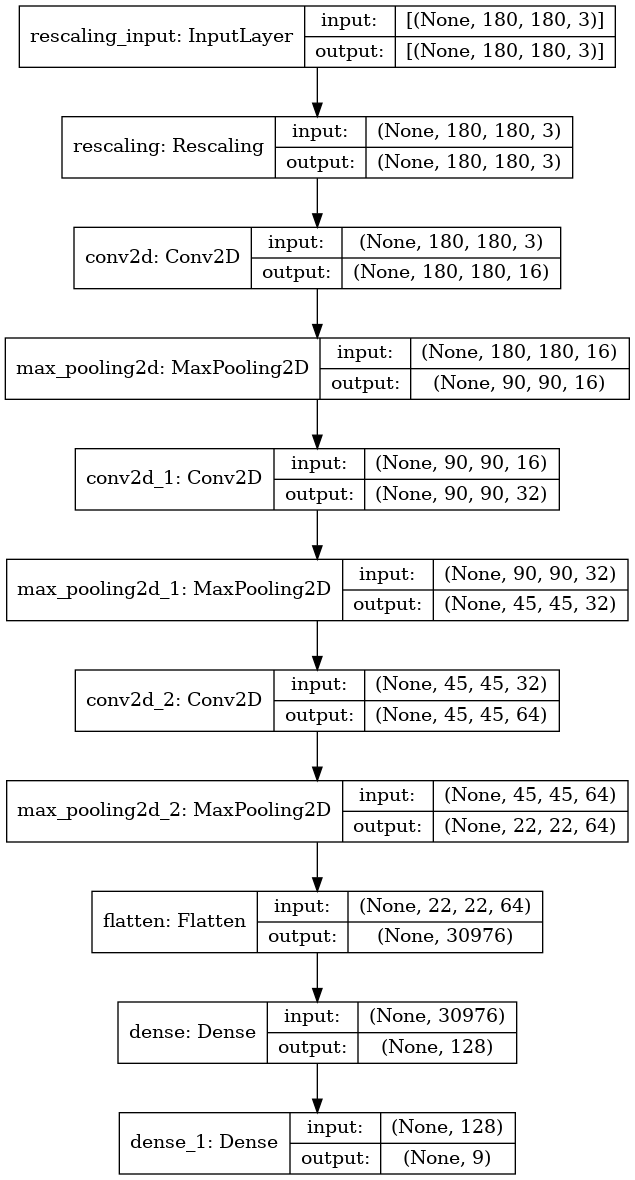

In [18]:
keras.utils.plot_model(model, show_shapes=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-11-14 18:04:55.247396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 32 of 1000
2022-11-14 18:04:59.655579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-14 18:05:00.479951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 27s 91ms/step - loss: 2.0116 - accuracy: 0.2550 - val_loss: 1.8739 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 1s 14ms/step - loss: 1.6618 - accuracy: 0.4196 - val_loss: 1.5335 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 14ms/step - loss: 1.4853 - accuracy: 0.4760 - val_loss: 1.5182 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 1s 14ms/step - loss: 1.3595 - accuracy: 0.5318 - val_loss: 1.4111 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 14ms/step - loss: 1.2764 - accuracy: 0.5547 - val_loss: 1.4009 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2001 - accuracy: 0.5798 - val_loss: 1.3974 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.1205 - accuracy: 0.6044 - val_loss: 1.3706 - val_accuracy: 0.5436
Epoch 8/20
56/56 [=====

### Visualizing training results

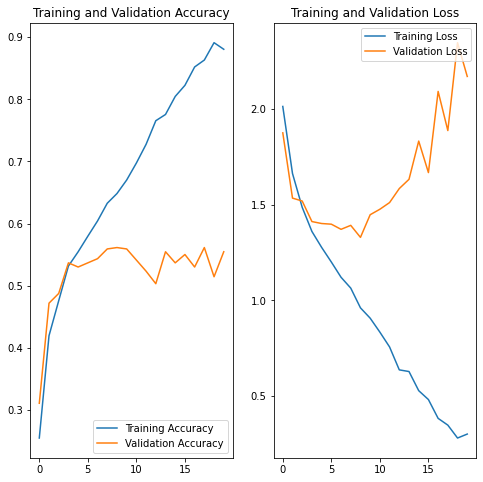

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

ANS: Traing Accuracy: 0.8811 and Validation accuracy: 0.5145 has huge difference which shows that data is overfitting

# Data Augmentation layer

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

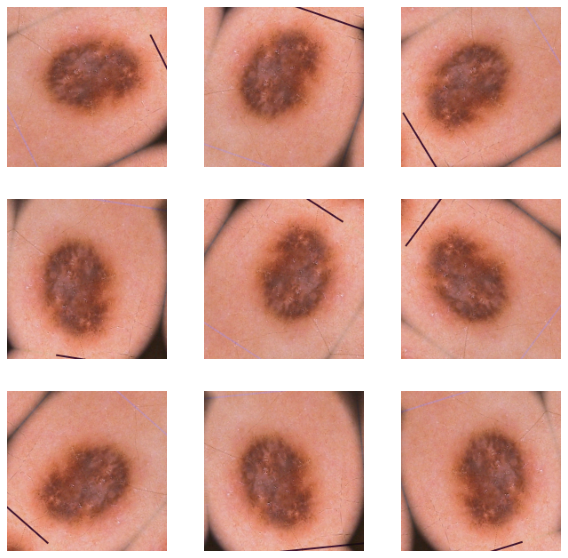

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for img,_ in train_ds.take(1):
    for i in range(9):
        aug_img = data_augmentation(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


# Model M2

In [25]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))

In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here

model = Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    #layers.Dropout(0.5),
    #layers.Dense(num_class,activation='softmax')
    layers.Dense(num_class,activation='softmax')
])

### Compiling the model

In [27]:
## Your code goes here
#model.compile(optimizer='adam',
#              loss="binary_crossentropy",
#              metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adadelta(),
              optimizer='adam',
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose=1,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 95ms/step - loss: 2.0928 - accuracy: 0.2031 - val_loss: 1.9712 - val_accuracy: 0.2237
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8720 - accuracy: 0.3080 - val_loss: 1.8515 - val_accuracy: 0.3154
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6696 - accuracy: 0.4163 - val_loss: 1.6372 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5721 - accuracy: 0.4520 - val_loss: 1.5003 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.5515 - accuracy: 0.4531 - val_loss: 1.4650 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 5s 90ms/step - loss: 1.4584 - accuracy: 0.4927 - val_loss: 1.4372 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 6s 100ms/step - loss: 1.4239 - accuracy: 0.5022 - val_loss: 1.4242 - val_accuracy: 0.5011
Epoch 8/20
5

### Visualizing the results

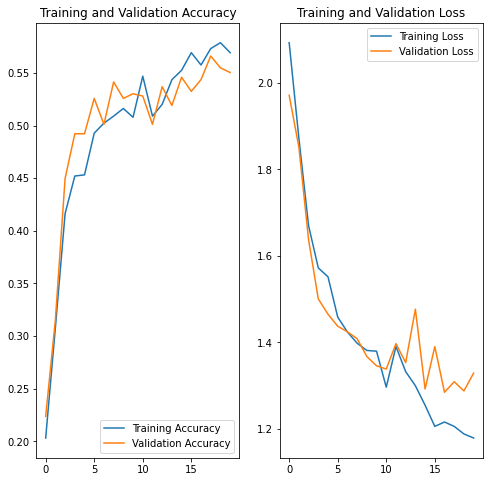

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Ans: The train accuracy: 0.5787 and the validation accuracy: 0.5459 doesn't have much difference. So overfitting has reduced for the second model

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

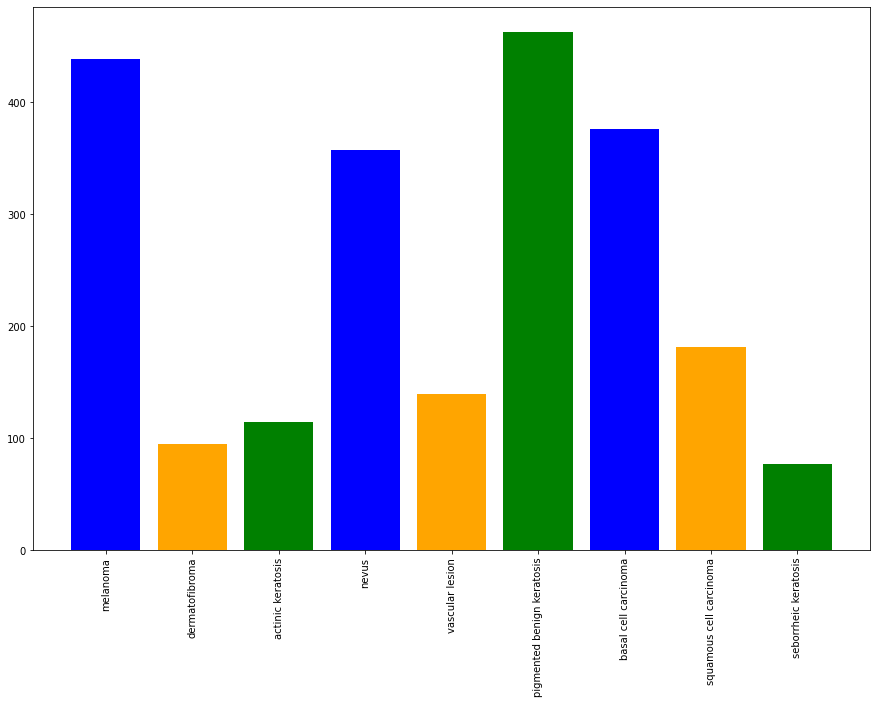

In [31]:
## Your code goes here.
## original_df - > path_list, lesion_list
from sklearn.datasets import load_files  
from keras.utils import np_utils
from collections import Counter
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_dir_train)
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
fig, ax1 = plt.subplots(1, 1, figsize= (15, 10))
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])
plt.xticks(rotation='vertical')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans: seborrheic keratosis classs has least samples
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: pigmented benign keratosis class dominates the data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [121]:

#import shutil
#shutil.rmtree("/kaggle/working/Augmented/")

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


# Augmentor Library layer code

In [122]:
path_to_training_dataset='../input/melanoma-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/Augmented/'+i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.4)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/Augmented/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DDD618A90>: 100%|██████████| 500/500 [00:17<00:00, 28.65 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/Augmented/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5DCFCA67D0>: 100%|██████████| 500/500 [00:15<00:00, 31.57 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/Augmented/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61C3A60850>: 100%|██████████| 500/500 [00:17<00:00, 28.57 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/Augmented/melanoma.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F61DA298ED0>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/Augmented/nevus.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F61C2330E10>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/Augmented/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62300C1110>: 100%|██████████| 500/500 [00:17<00:00, 28.92 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/Augmented/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5DDB285790>: 100%|██████████| 500/500 [00:38<00:00, 13.06 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/Augmented/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F623039EA10>: 100%|██████████| 500/500 [00:16<00:00, 29.69 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/Augmented/vascular lesion.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5DDB3706D0>: 100%|██████████| 500/500 [00:17<00:00, 28.13 Samples/s]


In [123]:
output_dir = pathlib.Path('/kaggle/working/Augmented/')

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [124]:
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [125]:
#path_list = [x for x in glob(os.path.join(path_to_training_dataset, '*','/kaggle/working', '*.jpg'))]
#path_list

In [126]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [127]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [128]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [129]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [130]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [131]:
data_dir_train="/kaggle/working/Augmented"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [132]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [133]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

# Model M3

In [134]:
## your code goes here
from keras import regularizers
model3 = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical" ,input_shape = (img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Rescaling(scale = 1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32,3,padding='same',activation= 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64,3,padding='same',activation= 'relu',kernel_regularizer=regularizers.l2(l=0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_class,activation='softmax')
    #layers.Dense(num_class)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [135]:
## your code goes here
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [136]:
model3.compile(#optimizer=Adam(learning_rate=0.001),
               optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [137]:
#model3.summary()

#### **Todo:**  Train your model

In [138]:
epochs = 50
## Your code goes here, use 50 epochs.
#history = # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
113/113 [==============================] - 12s 32ms/step - loss: 1.7095 - accuracy: 0.5817 - val_loss: 1.2030 - val_accuracy: 0.6600
Epoch 2/50
113/113 [==============================] - 2s 14ms/step - loss: 0.6814 - accuracy: 0.7806 - val_loss: 1.1498 - val_accuracy: 0.6911
Epoch 3/50
113/113 [==============================] - 2s 14ms/step - loss: 0.3942 - accuracy: 0.8614 - val_loss: 1.0042 - val_accuracy: 0.7456
Epoch 4/50
113/113 [==============================] - 2s 14ms/step - loss: 0.2381 - accuracy: 0.9103 - val_loss: 1.1206 - val_accuracy: 0.7522
Epoch 5/50
113/113 [==============================] - 2s 14ms/step - loss: 0.1639 - accuracy: 0.9397 - val_loss: 1.0969 - val_accuracy: 0.7556
Epoch 6/50
113/113 [==============================] - 2s 14ms/step - loss: 0.1214 - accuracy: 0.9517 - val_loss: 1.1091 - val_accuracy: 0.7711
Epoch 7/50
113/113 [==============================] - 2s 14ms/step - loss: 0.0975 - accuracy: 0.9614 - val_loss: 1.1587 - val_accuracy: 0.774

#### **Todo:**  Visualize the model results

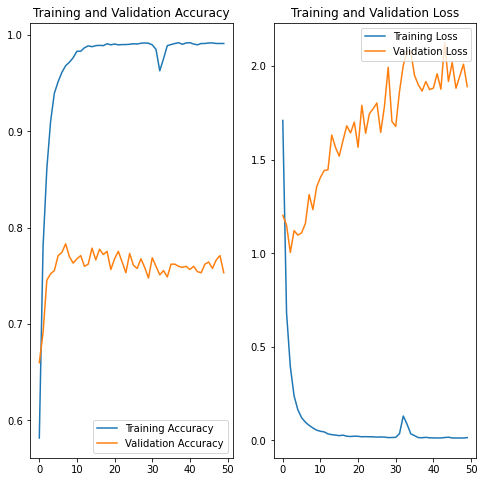

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Ans: Evan after class rebalance, we can observ that overfitting is still there adn accuracy score way hight than vlidation score


Model evaluation

In [140]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width),batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [3 0 5 4 2 7 3 7 7 8 0 0 0 7 1 1 1 1 5 2 2 8 7 4 2 1 0 3 4 2 7 6]


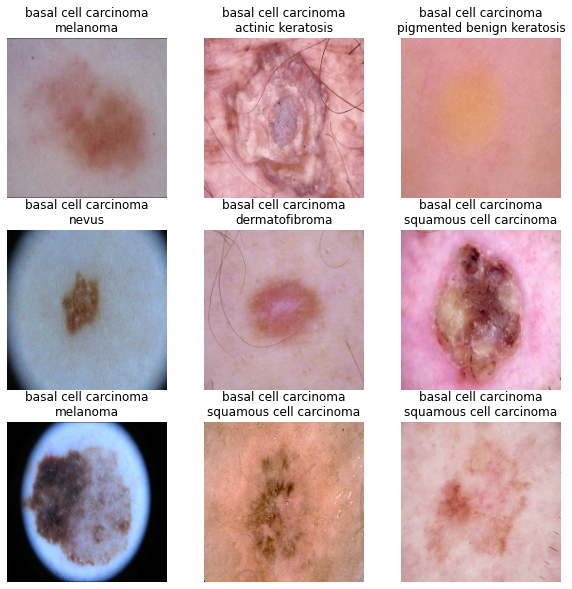

In [141]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")